In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

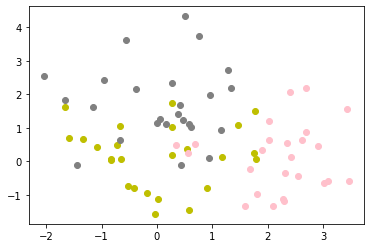

In [2]:
A_mean = [0,0]
A_cov = [[1,0],[0,1]]

A_data = pd.DataFrame(np.random.multivariate_normal(A_mean, A_cov, 25), columns=['x1', 'x2'])

B_mean = [2,0]
B_cov = [[0.5,0],[0,1]]

B_data = pd.DataFrame(np.random.multivariate_normal(B_mean, B_cov, 25), columns=['x1', 'x2'])

C_mean = [0,2]
C_cov = [[1,0.3],[0.3,1]]

C_data = pd.DataFrame(np.random.multivariate_normal(C_mean, C_cov, 25), columns=['x1', 'x2'])

data = pd.concat([A_data, B_data, C_data], ignore_index=True)

A_x1 = data.iloc[:25]['x1']
A_x2 = data.iloc[:25]['x2']
plt.scatter(A_x1, A_x2, c='y')
B_x1 = data.iloc[25:50]['x1']
B_x2 = data.iloc[25:50]['x2']
plt.scatter(B_x1, B_x2, c='pink')
C_x1 = data.iloc[50:]['x1']
C_x2 = data.iloc[50:]['x2']
plt.scatter(C_x1, C_x2, c='grey')

In [3]:
# 对两个点求距离
def distance(x, y):
    return math.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)


# 三种初始化中心的方式
def initial(data, pre, method='random'):
    if method == 'random':
        center = data.sample(n=3)
    elif method == 'far':
        # 随机获取中心1
        center1 = data.sample(n=1)
        # 所有点到中心1的距离
        dis1 = data.apply(lambda x: distance(x, center1.iloc[0]), axis=1)
        indice = dis1.sort_values().index[-1]
        # 选择最远的作为中心2
        center2 = pd.DataFrame(data.iloc[indice]).T
        # 所有点到中心2的距离
        dis2 = data.apply(lambda x: distance(x, center2.iloc[0]), axis=1)
        dis = dis1 + dis2
        indice = dis.sort_values().index[-1]
        # 选择距离和最远的点作为中心3
        center3 = pd.DataFrame(data.iloc[indice]).T
        center = pd.concat([center1, center2, center3])
    elif method == '++':
        # 随机获取中心1
        center1 = data.sample(n=1)
        # 所有点到中心1的距离
        dis1 = data.apply(lambda x: distance(x, center1.iloc[0]), axis=1)
        pro1 = dis1/dis1.sum()
        indice = np.random.choice(np.arange(len(pro1)), p=pro1)
        center2 = pd.DataFrame(data.iloc[indice]).T
        # 所有点到中心2的距离
        dis2 = data.apply(lambda x: distance(x, center2.iloc[0]), axis=1)
        dis = dis1 + dis2
        pro2 = dis/dis.sum()
        indice = np.random.choice(np.arange(len(pro2)), p=pro2)
        # 选择距离和最远的点作为中心3
        center3 = pd.DataFrame(data.iloc[indice]).T
        center = pd.concat([center1, center2, center3])
    else:
        print("指定方式有误，选择随机生成中心")
        center = data.sample(n=3)
    for i in range(3):
        pre[center.index[i]] = i + 1
    return center

In [4]:
def classify(data, pre, center):
    # 分别计算到三个点的距离
    dis1 = data.apply(lambda x: distance(x, center.iloc[0]), axis=1)
    dis2 = data.apply(lambda x: distance(x, center.iloc[1]), axis=1)
    dis3 = data.apply(lambda x: distance(x, center.iloc[2]), axis=1)
    for i in range(len(data)):
        if dis1[i] < dis2[i]:
            if dis1[i] < dis3[i]:
                pre[i] = 1
            else:
                pre[i] = 3
        else:
            if dis2[i] < dis3[i]:
                pre[i] = 2
            else:
                pre[i] = 3

In [5]:
# 求中点即求平均值，采用增量式更新(其实没有降低复杂度，因为处理的是内存信息而不是流式数据）
def find(data, pre, center):
    center[:][:] = 0
    count = np.zeros(3)
    for i in range(len(data)):
        if pre[i] == 1:
            count[0] += 1
            center.iloc[0] = center.iloc[0] + (data.iloc[i] - center.iloc[0])/count[0]
        if pre[i] == 2:
            count[1] += 1
            center.iloc[1] = center.iloc[1] + (data.iloc[i] - center.iloc[1])/count[1]
        if pre[i] == 3:
            count[2] += 1
            center.iloc[2] = center.iloc[2] + (data.iloc[i] - center.iloc[2])/count[2]

已经收敛
[3. 1. 1. 1. 3. 1. 3. 1. 1. 1. 1. 1. 3. 2. 1. 1. 3. 1. 1. 1. 1. 1. 1. 2.
 1. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 1. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3.
 3. 3. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1.
 3. 1. 2.]
已经收敛
[2. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 3. 1. 1. 2. 1. 1. 1. 1. 1. 1. 3.
 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 1. 3. 3. 3. 3. 3. 3. 1. 3. 1. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1.
 2. 1. 3.]
已经收敛
[3. 2. 2. 2. 3. 2. 3. 1. 2. 1. 2. 2. 3. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 1.
 2. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 2. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2.
 3. 1. 1.]


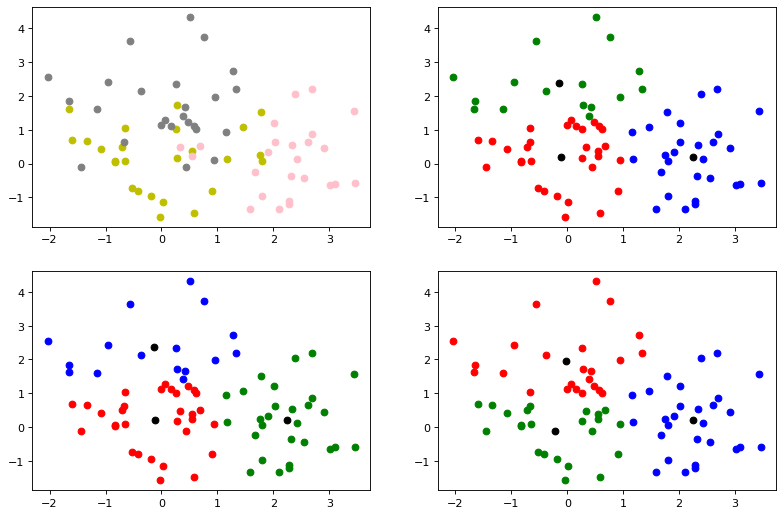

In [6]:
def train(data, method='random'):
    flag = False
    pre = np.zeros(len(data))
    center = initial(data, pre, method)
    classify(data, pre, center)
    
    # 循环更新直到收敛
    for _ in range(5000):
        pre_ = pre.copy()
        find(data, pre, center)
        classify(data, pre, center)
        if all(pre==pre_):
            print("已经收敛")
            flag = True
            break

    if flag:
        for i in range(len(data)):
            if pre[i] == 1:
                plt.scatter(data.iloc[i]['x1'], data.iloc[i]['x2'], c='r')
            elif pre[i] == 2:
                plt.scatter(data.iloc[i]['x1'], data.iloc[i]['x2'], c='g')
            else:
                plt.scatter(data.iloc[i]['x1'], data.iloc[i]['x2'], c='b')
        plt.scatter(center[:]['x1'], center[:]['x2'], c='black')
        print(pre)
    else:
        print("未能收敛")
        
# 创建画布
fig = plt.figure(figsize=(12, 8), dpi=80)
# 绘制分布
pic = fig.add_subplot(2, 2, 1)
A_x1 = data.iloc[:25]['x1']
A_x2 = data.iloc[:25]['x2']
plt.scatter(A_x1, A_x2, c='y')
B_x1 = data.iloc[25:50]['x1']
B_x2 = data.iloc[25:50]['x2']
plt.scatter(B_x1, B_x2, c='pink')
C_x1 = data.iloc[50:]['x1']
C_x2 = data.iloc[50:]['x2']
plt.scatter(C_x1, C_x2, c='grey')


# 随机获得初始中心
fig.add_subplot(2, 2, 2)
train(data, 'random')

# 最远
# 随机获得初始中心
fig.add_subplot(2, 2, 3)
train(data, 'far')

# ++
fig.add_subplot(2, 2, 4)
train(data, '++')